<a href="https://colab.research.google.com/github/yiwenwangANU/pytorch_review/blob/main/04_pytorch_customer_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Data download and explore

In [1]:
import torch
from torch.optim.lr_scheduler import StepLR
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)

100%|██████████| 586M/586M [00:33<00:00, 18.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2


In [ ]:
import os

for root, dirs, file in os.walk(path):
  print(f'Current directory: {root}')
  print(f'Subdirs: {dirs}')
  print(f'Number of Files: {len(file)}, Files: {file}')

In [4]:
translate_path =  path + '/translate.py'
with open(translate_path, 'r') as file:
    content = file.read()
    print(content)

translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "dog": "cane", "cavallo": "horse", "elephant" : "elefante", "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo"}



In [5]:
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "dog": "cane", "cavallo": "horse", "elephant" : "elefante", "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca", "ragno": "spider", "squirrel": "scoiattolo"}

In [6]:
data_path = path + '/raw-img'
data_path

'/root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/raw-img'

In [7]:
os.listdir(path)

['translate.py', 'raw-img']

In [8]:
import glob
total_images = glob.glob(data_path + "/**/*.jpeg") + glob.glob(data_path + "/**/*.jpg") + glob.glob(data_path + "/**/*.png")
print(f'Total number of animal images: {len(total_images)}')

Total number of animal images: 26179


In [9]:
for animal in os.listdir(data_path):
  curr_path = os.path.join(data_path, animal)
  images_number = len(glob.glob(curr_path + '/*.jpeg') + glob.glob(curr_path + '/*.jpg') + glob.glob(curr_path + '/*.png'))
  print(f'Number of {animal}: {images_number}')

Number of gatto: 1668
Number of pecora: 1820
Number of cavallo: 2623
Number of farfalla: 2112
Number of ragno: 4821
Number of elefante: 1446
Number of scoiattolo: 1862
Number of mucca: 1866
Number of cane: 4863
Number of gallina: 3098


In [10]:
#label encode aniaml classes
label_to_animal = {idx:animal for idx, animal in enumerate(os.listdir(data_path))}
label_to_animal

{0: 'gatto',
 1: 'pecora',
 2: 'cavallo',
 3: 'farfalla',
 4: 'ragno',
 5: 'elefante',
 6: 'scoiattolo',
 7: 'mucca',
 8: 'cane',
 9: 'gallina'}

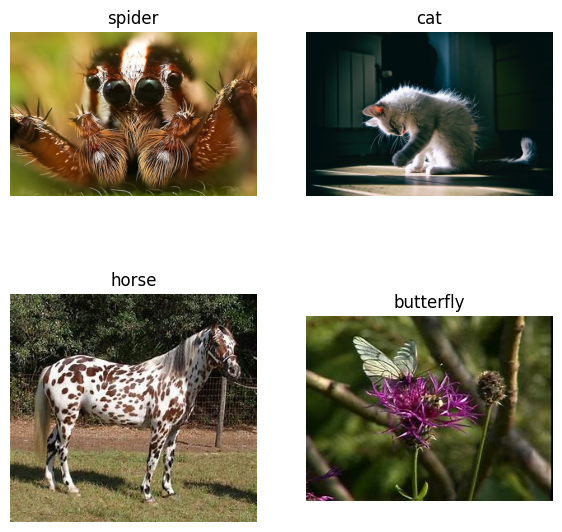

In [11]:
import random
import matplotlib.pyplot as plt
from PIL import Image

def plotRandomImages(rootdir):
  images = glob.glob(rootdir + "/**/*.jpeg") + glob.glob(rootdir + "/**/*.jpg") + glob.glob(rootdir + "/**/*.png")
  plt.figure(figsize=(7, 7))
  for i in range(4):
    random_image = random.choice(images)
    img = Image.open(random_image)
    plt.subplot(2, 2, i+1)
    plt.axis('off')
    plt.imshow(img)
    animal_class = translate[random_image.split('/')[-2]]
    plt.title(animal_class)
  plt.show()

plotRandomImages(data_path)

###Data Preprocessing

In [12]:
train_dir = os.path.join(path, 'train')
test_dir = os.path.join(path, 'test')
train_dir

'/root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/train'

In [13]:
import shutil

def recreate_dir(dir):
  if(os.path.exists(dir)):
    shutil.rmtree(dir)
  os.makedirs(dir)

recreate_dir(train_dir)
recreate_dir(test_dir)

os.listdir(path)

['translate.py', 'train', 'test', 'raw-img']

In [14]:
for label in os.listdir(data_path):
  os.makedirs(os.path.join(train_dir, label))
  os.makedirs(os.path.join(test_dir, label))
os.listdir(train_dir)

['gatto',
 'pecora',
 'cavallo',
 'farfalla',
 'ragno',
 'elefante',
 'scoiattolo',
 'mucca',
 'cane',
 'gallina']

In [15]:
for label in os.listdir(data_path):
  label_path = os.path.join(data_path, label)
  train_files = os.listdir(label_path)[:800]
  test_files = os.listdir(label_path)[800:1000]
  for file in train_files:
    file_path = os.path.join(label_path, file)
    shutil.copy(file_path, os.path.join(train_dir, label, file))
  for file in test_files:
    file_path = os.path.join(label_path, file)
    shutil.copy(file_path, os.path.join(test_dir, label, file))

In [ ]:
for root, dirs, file in os.walk(train_dir):
  print(f'Current directory: {root}')
  print(f'Subdirs: {dirs}')
  print(f'Number of Files: {len(file)}, Files: {file}')

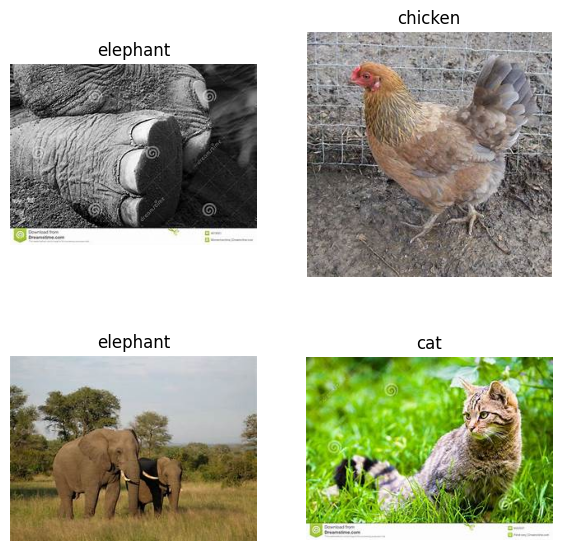

In [17]:
plotRandomImages(train_dir)

In [ ]:
for root, dirs, file in os.walk(test_dir):
  print(f'Current directory: {root}')
  print(f'Subdirs: {dirs}')
  print(f'Number of Files: {len(file)}, Files: {file}')

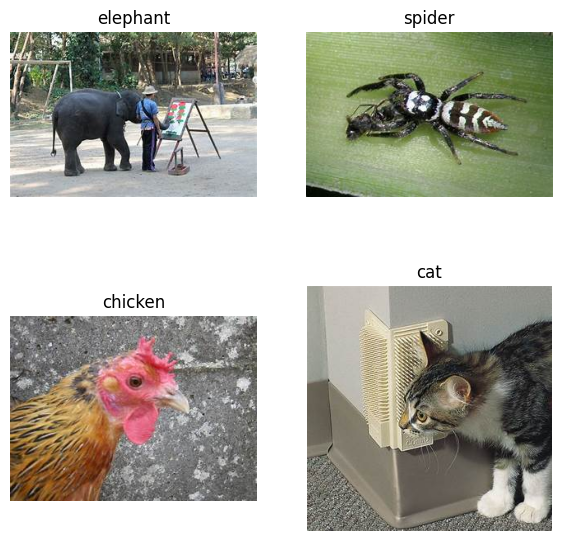

In [19]:
plotRandomImages(test_dir)

In [20]:
from torch.utils.data import Dataset

class AnimalDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.transform = transform
    self.image_paths = []
    self.labels = []
    self.label_dict = {idx:label for idx,label in enumerate(os.listdir(self.root_dir))} # {0: 'gatto',1: 'mucca', ...}
    self.count = 0

    for idx, label in self.label_dict.items():
      class_dir = os.path.join(root_dir, label)
      for file in os.listdir(class_dir):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')) and self.count < 100: # use first 100 images in each class
          self.count += 1
          self.image_paths.append(os.path.join(class_dir, file))
          self.labels.append(idx)
      self.count = 0

  def __len__(self):
    return len(self.labels)


  def __getitem__(self, idx):
    image = Image.open(self.image_paths[idx]).convert("RGB")
    label = self.labels[idx]
    if self.transform:
      image = self.transform(image)
    return image, label

In [21]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),         # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),         # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

In [22]:
train_dataset = AnimalDataset(root_dir=train_dir, transform=train_transforms)
test_dataset = AnimalDataset(root_dir=test_dir, transform=test_transforms)

In [41]:
len(train_dataset)

1000

In [23]:
random_samples_idx = random.sample(range(len(train_dataset)), k=4)
random_samples_idx

[929, 556, 917, 931]

In [24]:
def plotRandomDataset(dataset):
  random_samples_idx = random.sample(range(len(dataset)), k=4)
  for i, sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[sample][0], dataset[sample][1]
    targ_image_adjust = targ_image.permute(1, 2, 0)
    plt.subplot(2, 2, i+1)
    plt.axis('off')
    plt.imshow(targ_image_adjust)
    animal_class = translate[label_to_animal[targ_label]]
    plt.title(animal_class)

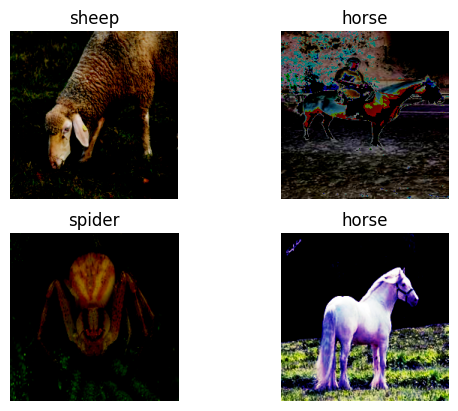

In [25]:
plotRandomDataset(train_dataset)

In [26]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 64

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [27]:
for batch_idx, (images, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f"Images shape: {images.shape}")  # Shape of the image tensor
    print(f"Labels shape: {labels.shape}")  # Shape of the label tensor
    print(f"Images data type: {images.dtype}")
    print(f"Labels data type: {labels.dtype}")
    print(f"First image tensor:\n{images[0]}")
    print(f"First label tensor: {labels[0]}")
    break  # Break after the first batch to avoid excessive output

Batch 1:
Images shape: torch.Size([64, 3, 224, 224])
Labels shape: torch.Size([64])
Images data type: torch.float32
Labels data type: torch.int64
First image tensor:
tensor([[[-1.0000, -1.0000, -1.0000,  ..., -0.8118, -0.8745, -0.9059],
         [-1.0000, -1.0000, -0.9686,  ..., -0.8275, -0.8745, -0.8902],
         [-1.0000, -0.9686, -0.9373,  ..., -0.8118, -0.8431, -0.8745],
         ...,
         [-0.9373, -1.0000, -0.9529,  ..., -0.8902, -0.8902, -0.8902],
         [-0.8588, -0.9686, -0.9686,  ..., -0.8745, -0.8588, -0.8275],
         [-0.7647, -0.9216, -0.9686,  ..., -0.8902, -0.8275, -0.7647]],

        [[-0.9529, -0.9373, -0.9373,  ..., -0.5922, -0.6549, -0.6863],
         [-0.9686, -0.9373, -0.9059,  ..., -0.6078, -0.6549, -0.6706],
         [-0.9529, -0.9216, -0.8902,  ..., -0.6078, -0.6235, -0.6549],
         ...,
         [-0.9529, -1.0000, -0.9686,  ..., -0.9059, -0.9059, -0.9059],
         [-0.8902, -0.9843, -0.9686,  ..., -0.8902, -0.8745, -0.8431],
         [-0.7804, -0.9

###VGG16 with random initial weights

In [28]:
from torch import nn

class VGG16(nn.Module):
  def __init__(self):
    super().__init__()
    self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
    self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 10),
        )
  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)  # Flatten the tensor
    x = self.classifier(x)
    return x

model = VGG16().to(device)

In [29]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model, input_size=[1, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
VGG16                                    [1, 10]                   --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

In [34]:
def train(model: torch.nn.Module,
          train_loader: torch.utils.data.DataLoader,
          test_loader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          scheduler: torch.optim.lr_scheduler,
          epoches: int = 10):

  results = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
    }
  for epoch in range(epoches):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = len(train_loader.dataset)
    for X_train, y_train in train_loader:
      X_train, y_train = X_train.to(device), y_train.to(device)
      y_logits = model(X_train)
      loss = loss_fn(y_logits, y_train)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
      train_pred = torch.argmax(y_logits, dim=1)
      train_correct += (train_pred == y_train).sum().item()
    train_loss /= len(train_loader)
    train_acc = train_correct / train_total

    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = len(test_loader.dataset)
    with torch.inference_mode():
      for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        test_logits = model(X_test)
        loss = loss_fn(test_logits, y_test)
        test_pred = torch.argmax(test_logits, dim=1)
        test_loss += loss.item()
        test_correct += (test_pred == y_test).sum().item()
    test_loss /= len(test_loader)
    test_acc = test_correct / test_total
    scheduler.step()

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    print(f'epoch: {epoch}, train_loss: {train_loss:.4f}, train accuracy: {train_acc:.4f}, test loss: {test_loss:.4f}, test accuracy: {test_acc:.4f}')
  return results

In [35]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

vgg16_results = train(model=model,
                      train_loader=train_loader,
                      test_loader=test_loader,
                      loss_fn=nn.CrossEntropyLoss(),
                      optimizer = optimizer,
                      scheduler = scheduler,
                      epoches=10)

epoch: 0, train_loss: 2.3035, train accuracy: 0.1000, test loss: 2.3025, test accuracy: 0.1000
epoch: 1, train_loss: 2.3028, train accuracy: 0.1000, test loss: 2.3026, test accuracy: 0.1000
epoch: 2, train_loss: 2.3029, train accuracy: 0.0980, test loss: 2.3027, test accuracy: 0.1000
epoch: 3, train_loss: 2.3028, train accuracy: 0.1000, test loss: 2.3025, test accuracy: 0.1000
epoch: 4, train_loss: 2.3027, train accuracy: 0.0960, test loss: 2.3025, test accuracy: 0.1000
epoch: 5, train_loss: 2.3027, train accuracy: 0.1060, test loss: 2.3025, test accuracy: 0.1000
epoch: 6, train_loss: 2.3025, train accuracy: 0.1050, test loss: 2.3025, test accuracy: 0.1000
epoch: 7, train_loss: 2.3027, train accuracy: 0.1020, test loss: 2.3025, test accuracy: 0.1000
epoch: 8, train_loss: 2.3028, train accuracy: 0.0960, test loss: 2.3025, test accuracy: 0.1000
epoch: 9, train_loss: 2.3025, train accuracy: 0.1000, test loss: 2.3025, test accuracy: 0.1000


###Pretained VGG16 and EfficientNet

In [36]:
from torchvision import models

# Load the VGG16 model (pretrained on ImageNet)
vgg16 = models.vgg16(pretrained=True)

vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 4096),  # Input: 25088 (default VGG16 output)
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(4096, 1024),  # Additional layer
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),  # Additional layer
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(512, 10)  # Output layer for 10 classes
)
# Pretrained Features Frozen
for param in vgg16.features.parameters():
    param.requires_grad = False

vgg16 = vgg16.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 83.1MB/s]


In [37]:
optimizer = torch.optim.Adam(params=vgg16.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

vgg16_pretrained_results = train(model=vgg16,
                                train_loader=train_loader,
                                test_loader=test_loader,
                                loss_fn=nn.CrossEntropyLoss(),
                                optimizer = optimizer,
                                scheduler = scheduler,
                                epoches=10)

epoch: 0, train_loss: 2.1173, train accuracy: 0.2530, test loss: 1.5501, test accuracy: 0.7910
epoch: 1, train_loss: 1.3985, train accuracy: 0.5670, test loss: 0.7366, test accuracy: 0.8100
epoch: 2, train_loss: 0.9709, train accuracy: 0.6660, test loss: 0.4844, test accuracy: 0.8370
epoch: 3, train_loss: 0.6952, train accuracy: 0.7750, test loss: 0.3590, test accuracy: 0.8830
epoch: 4, train_loss: 0.5034, train accuracy: 0.8360, test loss: 0.3680, test accuracy: 0.8790
epoch: 5, train_loss: 0.3985, train accuracy: 0.8750, test loss: 0.3092, test accuracy: 0.8940
epoch: 6, train_loss: 0.4141, train accuracy: 0.8690, test loss: 0.3058, test accuracy: 0.8960
epoch: 7, train_loss: 0.3810, train accuracy: 0.8850, test loss: 0.2930, test accuracy: 0.9020
epoch: 8, train_loss: 0.4091, train accuracy: 0.8850, test loss: 0.2924, test accuracy: 0.9030
epoch: 9, train_loss: 0.3754, train accuracy: 0.8840, test loss: 0.2902, test accuracy: 0.9020


In [38]:
# Load EfficientNetB7 pretrained on ImageNet
efficientnet_b7 = models.efficientnet_b7(pretrained=True)

for param in efficientnet_b7.features.parameters():
    param.requires_grad = False

efficientnet_b7.classifier = nn.Sequential(
    nn.Linear(efficientnet_b7.classifier[1].in_features, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Dropout(0.5),
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256, 10)  # Output layer for 10 classes
)

efficientnet_b7 = efficientnet_b7.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 160MB/s]


In [39]:
optimizer = torch.optim.Adam(efficientnet_b7.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

efficientnet_pretrained_results = train(model=efficientnet_b7,
                                        train_loader=train_loader,
                                        test_loader=test_loader,
                                        loss_fn=nn.CrossEntropyLoss(),
                                        optimizer = optimizer,
                                        scheduler = scheduler,
                                        epoches=10)

epoch: 0, train_loss: 2.5170, train accuracy: 0.1230, test loss: 2.2779, test accuracy: 0.1000
epoch: 1, train_loss: 2.3012, train accuracy: 0.1750, test loss: 2.1011, test accuracy: 0.1890
epoch: 2, train_loss: 2.0865, train accuracy: 0.2790, test loss: 1.7095, test accuracy: 0.6460
epoch: 3, train_loss: 1.8453, train accuracy: 0.3880, test loss: 1.3654, test accuracy: 0.7670
epoch: 4, train_loss: 1.7308, train accuracy: 0.4450, test loss: 1.1665, test accuracy: 0.7960
epoch: 5, train_loss: 1.6253, train accuracy: 0.4940, test loss: 1.1699, test accuracy: 0.7990
epoch: 6, train_loss: 1.6097, train accuracy: 0.4860, test loss: 1.1711, test accuracy: 0.7930
epoch: 7, train_loss: 1.6050, train accuracy: 0.4890, test loss: 1.1747, test accuracy: 0.7940
epoch: 8, train_loss: 1.5848, train accuracy: 0.5060, test loss: 1.1886, test accuracy: 0.7880
epoch: 9, train_loss: 1.5902, train accuracy: 0.5030, test loss: 1.1933, test accuracy: 0.7810


###Evaluate the result

In [48]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(10, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

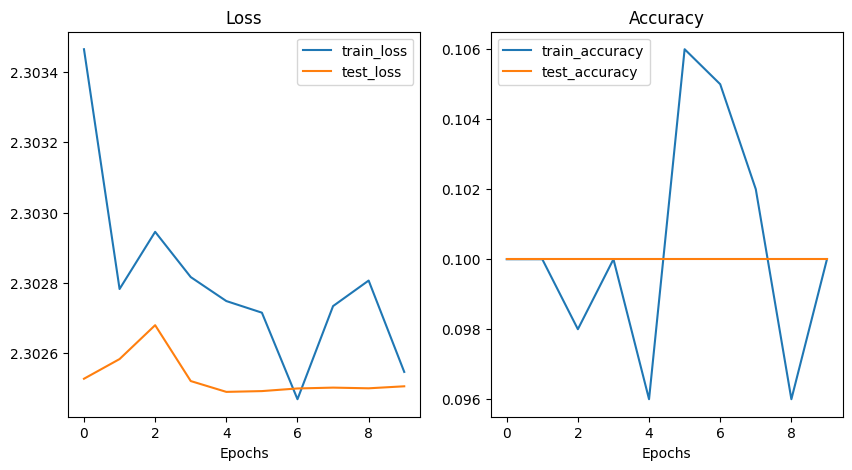

In [49]:
plot_loss_curves(vgg16_results)

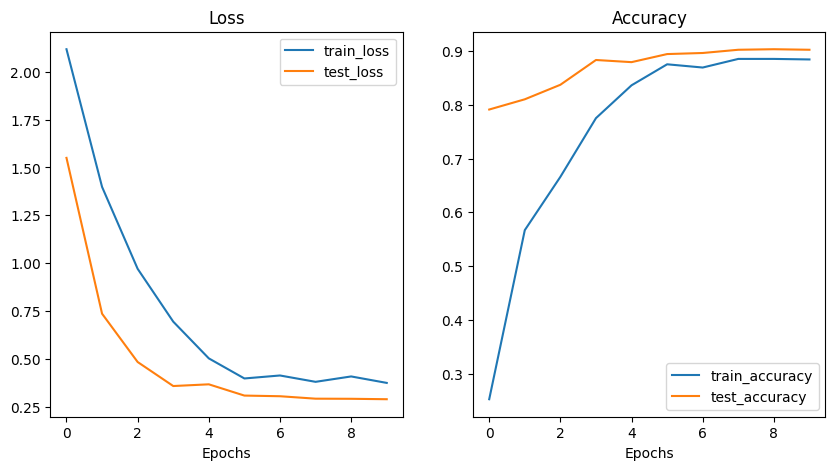

In [50]:
plot_loss_curves(vgg16_pretrained_results)

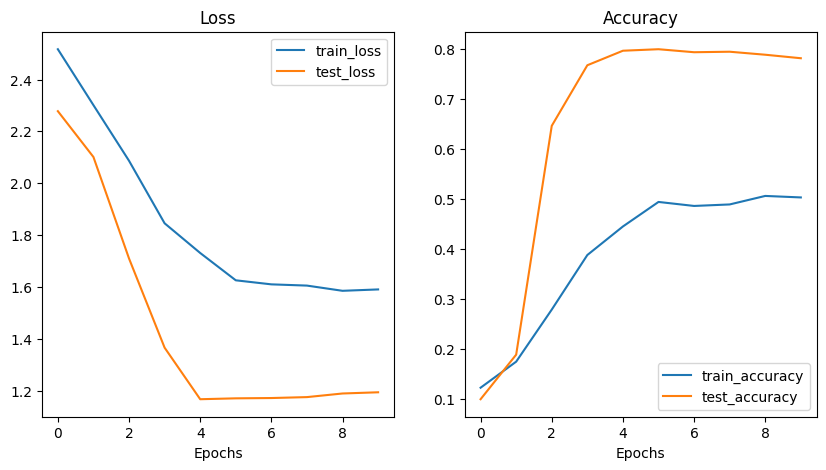

In [51]:
plot_loss_curves(efficientnet_pretrained_results)

### Why results so different

When working with a small dataset like this(10 classes with 100 images in each class), the pretrained model has a significant advantage because it transfers knowledge from the large ImageNet dataset.

With convolutional layers start with random weights and biases, the model must learn everything from scratch, including basic image features like edges and textures. For small dataset, the model struggles to generalize because it lacks enough data to adequately train such a deep network from scratch.